<img src="JFM-notebooks-logo.jpg" style="max-width:100%" />

### Imports

In [3]:
import sys, os
os.environ['NOWARNINGS'] = '1'
sys.path.append(os.path.join('Code'))
from load_data import load_data
from postprocessing.plotting import *
plotting_defaults()
plt.rcParams['figure.dpi'] = 150 # to adjust display size in notebook
ref, refsim, transient, varsim_list = load_data('Data', include_ensemble=False)
textwidth = 5.31445

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from postprocessing.plotting import *

### Generate figure

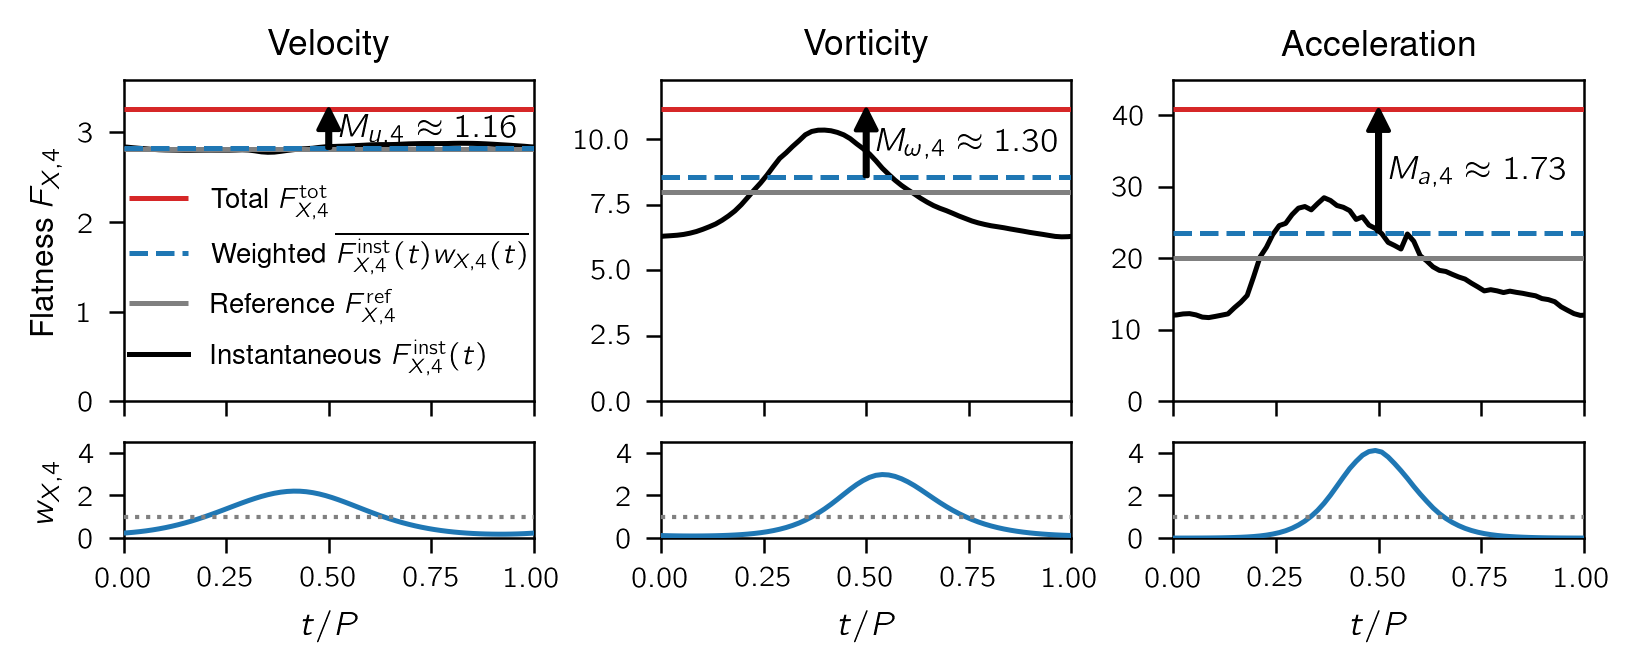

In [5]:
# select simulation and bin number
varsim = varsim_list[8]
binno = 64

# set up figure
fig, ax_list = plt.subplots(nrows=2, ncols=3,
    figsize=(textwidth, 0.4*textwidth), sharex='col',
    gridspec_kw={'height_ratios':[1,0.3]})
fig.get_layout_engine().set(rect=(0.0025, 0., 1., 1.))
axs = {'vel':ax_list[0,0], 'vort':ax_list[0,1], 'acc':ax_list[0,2],
       'varvel':ax_list[1,0], 'varvort':ax_list[1,1], 'varacc':ax_list[1,2]}
axs['vel'].set_title('Velocity')
axs['vort'].set_title('Vorticity')
axs['acc'].set_title('Acceleration')
fig.get_layout_engine().set(w_pad=0.02, wspace=0.02)

# temporal bins
t_bins_fine = varsim.get_tbins(binno, minsize=ref.tauK/2)
t_bincenters_fine = (t_bins_fine[1:] + t_bins_fine[:-1])/2.
t_bincenters_padded = np.concatenate([
    [t_bincenters_fine[-1] - varsim.get_period()],
    t_bincenters_fine,
    [t_bincenters_fine[0] + varsim.get_period()]
])
t0, t1 = varsim.trange_fullperiods(transient)

# iterate over quantities
for quantity in ['vel', 'vort', 'acc']:

    ## variance plot
    plt.sca(axs[f'var{quantity}'])
    axs[f'var{quantity}'].sharex(axs[quantity])
    variance = varsim.periodic_average(
        varsim.statistics[f'moments/{quantity}'][:,2], t_bins_fine, transient)
    mean_variance = np.mean(varsim.statistics[f'moments/{quantity}'][t0:t1,2])
    weighting = variance**2/np.mean(variance**2)
    weighting_padded = np.concatenate([
        [weighting[-1]],
        weighting,
        [weighting[0]]
    ])
    plt.plot(t_bincenters_padded/varsim.get_period(),
        weighting_padded, c='C0',
        label='Instantaneous', zorder=5)
    plt.hlines(1, 0, 1, color='grey', zorder=10, lw=1, ls=':')
    plt.xlabel(r'$t/P$')
    plt.yticks([0,2,4])
    plt.ylim(0, 4.5)
    if quantity == 'vel':
        plt.ylabel(r'$w_{X,4}$')

    ## flatness plot
    plt.sca(axs[quantity])

    # total flatness
    mean_fourth_moment = np.mean(varsim.statistics[f'moments/{quantity}'][t0:t1,4])
    total_flatness = mean_fourth_moment/mean_variance**2
    plt.hlines(total_flatness, 0, 1,
        color='tab:red', zorder=9, label=r'Total $F_{X,4}^\mathrm{tot}$')

    # weighted average flatness
    fourth_moment = varsim.periodic_average(
        varsim.statistics[f'moments/{quantity}'][:,4], t_bins_fine, transient)
    flatness = fourth_moment/variance**2
    weighted_average = np.mean(flatness*variance**2)/np.mean(variance**2)
    plt.hlines(weighted_average, 0, 1, color='tab:blue', zorder=8,
        ls='--', label=r'Weighted $\overline{F^\mathrm{inst}_{X,4}(t)w_{X,4}(t)}$')

    # reference flatness
    refflatness = np.mean(refsim.statistics[f'moments/{quantity}'][:,4]) \
                 /np.mean(refsim.statistics[f'moments/{quantity}'][:,2])**2
    plt.hlines(refflatness, 0, 1, color='grey', zorder=7,
        label=r'Reference $F^\mathrm{ref}_{X,4}$')

    # instantaneous flatness
    flatness_padded = np.concatenate([
        [flatness[-1]],
        flatness,
        [flatness[0]]
    ])
    plt.plot(t_bincenters_padded/varsim.get_period(),
        flatness_padded, c='black',
        label=r'Instantaneous $F^\mathrm{inst}_{X,4}(t)$', zorder=6)

    # multiplier
    multiplier = np.mean(variance**2)/np.mean(variance)**2
    symbol = {'vel': 'u', 'vort': r'\omega', 'acc': 'a'}[quantity]
    plt.annotate('',
        xy=(0.5, total_flatness), 
        xytext=(0.5, weighted_average), 
        arrowprops=dict(facecolor='black', shrink=0.01, width=0.7, headwidth=5, headlength=5),
        horizontalalignment='left',
        verticalalignment='bottom',
        zorder = 50
        )
    plt.text(0.525, (total_flatness + weighted_average)/2,
        r'$M_{{{},4}} \approx {:.2f}$'.format(
            symbol, np.round(multiplier, 2)),
        ha="left", va="center", fontdict={'size':8},
        zorder = 50
        )

    # range and labels
    plt.xlim(0, 1)
    plt.ylim(0, np.maximum(np.amax(flatness), total_flatness)*1.1)
    if quantity == 'vel':
        plt.ylabel(r'Flatness $F_{X,4}$')
        plt.legend(frameon=False, loc="lower center")